# Section 3_1 MLP networks


## creation of the dataset (target values)

```Python
from dolfinx import mesh as msh, fem, io, default_scalar_type
from mpi4py import MPI
import os
import torch
import numpy as np
import ufl
from mpi4py import MPI
import numpy as np
from utils.FEniCSx_solver import FEniCSx_solver
from utils.FEniCSx_PyTorch_interface import FEniCSx_PyTorch_interface


class model(torch.nn.Module):
    def __init__(self, device, dtype, dir= None):
        super().__init__()
        self.w = torch.nn.Parameter(torch.rand(8, device=device, dtype=dtype, requires_grad=True))
        if dir is not None:
            self.load_state_dict(torch.load(dir, weights_only=True))

    
    def forward(self, x):
        a = torch.sqrt(x[0]**2+x[1]**2)
        b = torch.sqrt(x[2]**2+x[3]**2)
        c = torch.sqrt(x[4]**2+x[5]**2)
        s = (a+b+c)/2
        A = torch.sqrt(s*((s-a)*(s-b)*(s-c)))
        h_K = 4*A/torch.sqrt(a**2+b**2+c**2)
        limit = h_K**2/(1e-8*48)
        low = torch.zeros_like(limit)
        z1 = torch.matmul(self.w, x)
        Pe = z1/(2*1e-8)
        z2 = z1/2*(1/torch.tanh(Pe)-(2*1e-8)*z1)
        supg_params = torch.clip(z2, min = low, max=limit)
        return supg_params
    
model_init='data/example_2_1/models/nn_init.pth'

nn= model(device='cpu', dtype=torch.float64, dir=model_init)
w = nn.state_dict()['w'].detach().numpy()


mean = 0


def mesh_to_x(mesh, cell_ind_to_grid, epsK, bK, cK, fK, non_perturbed=False, device=None, dtype=None):
    lst = []
    for v in mesh.geometry.x[:,0:2][mesh.geometry.dofmap]:
        xK = np.concat((v, epsK, bK, cK, fK), axis=None)
        lst.append(xK)

    xnp=np.array(lst).T
    x = torch.tensor(xnp[:,cell_ind_to_grid], requires_grad=False, device=device, dtype=dtype)

    x = torch.nn.functional.pad(x, pad=(1,1,1,1))

    # left column: set v0, v1 to v0, v1 of neighboring column
    x[0:4,1:ny+1, 0] = x[0:4,1:ny+1, 1]
    # set collapsed vertices v2 and v3 to v1 at the same position
    x[4:6,1:ny+1, 0] = x[2:3,1:ny+1, 0]
    x[6:8,1:ny+1, 0] = x[2:3,1:ny+1, 0]


    # right column: set v0 to v2 of neighboring column
    x[0:4,1:ny+1, -1] = x[4:8,1:ny+1, -1 -1]
    # set collapsed vertices v2 and v3 to v1 at the same position
    x[4:6,1:ny+1, -1] = x[2:3,1:ny+1, -1]
    x[6:8,1:ny+1, -1] = x[2:3,1:ny+1, -1]


    # top row: set v0 to v0 of neighboring row
    x[0:2,0,1:nx+1] = x[2:4,1,1:nx+1]
    # top row: set v1 to v3 of neighboring row
    x[2:4,0,1:nx+1] = x[6:8,1,1:nx+1]
    # set collapsed vertices v2 and v3 to v1 at the same position
    x[4:6,0,1:nx+1] = x[2:3,0,1:nx+1]
    x[6:8,0,1:nx+1] = x[2:3,0,1:nx+1]

    # bottom row: set v0 to v0 of neighboring row
    x[0:2,-1,1:nx+1] = x[0:2,-1-1,1:nx+1]
    # bottom row: set v1 to v2 of neighboring row
    x[2:4,-1,1:nx+1] = x[4:6,-1-1,1:nx+1]
    # set collapsed vertices v2 and v3 to v1 at the same position
    x[4:6,-1,1:nx+1] = x[2:3,-1,1:nx+1]
    x[6:8,-1,1:nx+1] = x[2:3,-1,1:nx+1]

    # set upper left corner to v0 of neigboring horizontal edge
    x[0:2,0,0] = x[0:2,0,1]
    # set remaining vertices to v0
    x[2:4,0,0] = x[0:2,0,0]
    x[4:6,0,0] = x[0:2,0,0]
    x[6:8,0,0] = x[0:2,0,0]

    # set bottom left corner to v0 of neighboring horizontal edge
    x[0:2,-1,0] = x[0:2,-1,1]
    # set remaining vertices to v0
    x[2:4,-1,0] = x[0:2,-1,0]
    x[4:6,-1,0] = x[0:2,-1,0]
    x[6:8,-1,0] = x[0:2,-1,0]

    # set upper right corner to v1 of neighboring horizontal edge
    x[0:2,0,-1] = x[2:4,0,-1-1]
    # set remaining vertices to v0
    x[2:4,0,-1] = x[0:2,0,-1]
    x[4:6,0,-1] = x[0:2,0,-1]
    x[6:8,0,-1] = x[0:2,0,-1]

    # set bottom right corner to v1 of neighboring horizontal edge
    x[0:2,-1,-1] = x[2:4,-1,-1-1]
    # set remaining vertices to v0
    x[2:4,-1,-1] = x[0:2,-1,-1]
    x[4:6,-1,-1] = x[0:2,-1,-1]
    x[6:8,-1,-1] = x[0:2,-1,-1]

    # set the dirichlet boundary condition
    x[11,0,:] = 1
    x[11,-1,:] = 1
    x[11,:,0] = 1
    x[11,:,-1] = 1

    if non_perturbed:
        if np.all(bK == np.array([1,0])):
            x[12,0,:] = (x[0,0,:] + x[2,0,:])/2
            x[12,-1,:] = (x[0,-1,:] + x[2,-1,:])/2
            x[12,:,0] = (x[0,:,0] + x[2,:,0])/2
            x[12,:,-1] = (x[0,:,-1] + x[2,:,-1])/2
        if np.all(bK == np.array([-1,0])):
            x[12,0,:] = ((x[0,0,:] + x[2,0,:])/2).flip(0)
            x[12,-1,:] = ((x[0,-1,:] + x[2,-1,:])/2).flip(0)
            x[12,:,0] = ((x[0,:,0] + x[2,:,0])/2).flip(0)
            x[12,:,-1] = ((x[0,:,-1] + x[2,:,-1])/2).flip(0)
        if np.all(bK == np.array([0,1])):
            x[12,0,:] = (x[1,0,:] + x[3,0,:])/2
            x[12,-1,:] = (x[1,-1,:] + x[3,-1,:])/2
            x[12,:,0] = (x[1,:,0] + x[3,:,0])/2
            x[12,:,-1] = (x[1,:,-1] + x[3,:,-1])/2
        if np.all(bK == np.array([0,-1])):
            x[12,0,:] = ((x[1,0,:] + x[3,0,:])/2).flip(0)
            x[12,-1,:] = ((x[1,-1,:] + x[3,-1,:])/2).flip(0)
            x[12,:,0] = ((x[1,:,0] + x[3,:,0])/2).flip(0)
            x[12,:,-1] = ((x[1,:,-1] + x[3,:,-1])/2).flip(0)


    return x



def create_target_values(mesh, bK, non_perturbed=False):
    Wh = fem.functionspace(mesh, ('P', 2))
    mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)
    boundary_facets = msh.exterior_facet_indices(mesh.topology)
    boundary_dofs = fem.locate_dofs_topological(Wh, mesh.topology.dim-1, boundary_facets)

    eps = fem.Constant(mesh, default_scalar_type(1e-8))

    b = ufl.as_vector((fem.Constant(mesh, default_scalar_type(bK[0])),fem.Constant(mesh, default_scalar_type(bK[1]))))
    f = fem.Constant(mesh, default_scalar_type(1.0))
    uh = fem.Function(Wh)

    x = ufl.SpatialCoordinate(mesh)
    if np.all(bK == np.array([1,0])) or np.all(bK == np.array([-1,0])):
        dir = 0
    else:
        dir = 1
    ex_exp = x[dir]*(1-ufl.exp(-(1-x[dir])/eps))* (1 - (((ufl.exp(-(1-x[(dir+1)%2])/eps)  + ufl.exp(-(x[(dir+1)%2])/eps)))- ufl.exp(-(1)/eps))/(1-ufl.exp(-1/eps)))

    if np.min(bK) < 0:
        ex_exp = (1-x[dir])*(1-ufl.exp(-(x[dir])/eps))* (1 - (((ufl.exp(-(1-x[(dir+1)%2])/eps)  + ufl.exp(-(x[(dir+1)%2])/eps)))- ufl.exp(-(1)/eps))/(1-ufl.exp(-1/eps)))

    bcs = [fem.dirichletbc(fem.Constant(mesh, default_scalar_type(0.0)), boundary_dofs, Wh)]

    if non_perturbed:
        ex_exp = x[dir]
        if np.min(bK) < 0:
            ex_exp = 1 - ex_exp
        exp = fem.Expression(ex_exp, Wh.element.interpolation_points())

        u_ex = fem.Function(Wh)
        u_ex.interpolate(exp)
        bcs = [fem.dirichletbc(u_ex, boundary_dofs)]
        
    exp = fem.Expression(ex_exp, Wh.element.interpolation_points())

    u_ex = fem.Function(Wh)
    u_ex.interpolate(exp)

    loss = (uh-u_ex)**2 * ufl.dx
    pde_data = mesh,Wh,uh,eps,b,None,f,None,bcs

    FEniCSx = FEniCSx_solver(pde_data=pde_data, loss_form=loss)

    lst = []
    bK = np.array([1,0])
    for v in mesh.geometry.x[:,0:2][mesh.geometry.dofmap]:
        xK = np.concat((v[2]-v[1], v[2]-v[0], v[1]-v[0], bK), axis=None)
        lst.append(xK)

    xnp=np.array(lst).T
    z1 = np.matmul(w, xnp)
    Pe = z1/(2*1e-8)
    supg_params = z1/2*(1/np.tanh(Pe)-(2*1e-8)*z1)

    FEniCSx.set_weights(supg_params)
    params = torch.tensor(supg_params, requires_grad=True)
    autograd_func = FEniCSx_PyTorch_interface.apply

    def fem_solver(weights):
        return autograd_func(weights, FEniCSx)

    optimizer = torch.optim.Adam([params])
    train_loss = 0
    for steps in range(iterations):
        optimizer.zero_grad()
        loss = fem_solver(params)
        loss.backward()
        # Backpropagation
        optimizer.step()

    train_loss += loss
    target = params
    return target



iterations = 500
comm = MPI.COMM_WORLD
epsK = 1e-8
cK = 0
fK = 1


num = 0

nx = 32
ny = 32
std = 1/(3*(nx+ny))

mesh = msh.create_unit_square(comm, nx, ny, msh.CellType.quadrilateral)
Yh = fem.functionspace(mesh, ('DG', 0))
pts = Yh.tabulate_dof_coordinates()
x = pts[:,0]
y = pts[:,1]
cell_ind_to_grid = np.lexsort((pts[:,0], -pts[:,1])).reshape(ny,nx)

vertices = mesh.geometry.x

cells = mesh.geometry.dofmap

element = mesh.geometry.cmap
mask= ~np.any((vertices[:,:2] == 0) | (vertices[:,:2] == 1), axis=1)
for bK in [np.array([1,0]), np.array([-1,0]), np.array([0,1]), np.array([0,-1])]:
    for non_perturbed in [True, False]:
        #with io.XDMFFile(mesh.comm, f"data/example_3_1/training_set/fem_data/mesh_{num}.xdmf", "w") as writer:
        #    writer.write_mesh(ms)
        x = mesh_to_x(mesh=mesh, cell_ind_to_grid=cell_ind_to_grid,epsK=epsK, bK=bK, cK=cK, fK=fK,non_perturbed=non_perturbed)
        torch.save(x, f'data/example_3_1/training_set/inputs/x_{num}.pt')
        t = create_target_values(mesh=mesh, bK=bK, non_perturbed=non_perturbed)
        torch.save(t, f'data/example_3_1/training_set/target_values/t_{num}.pt')
        num += 1

for i in range(50):
    for bK in [np.array([1,0]), np.array([-1,0]), np.array([0,1]), np.array([0,-1])]:
        for non_perturbed in [True, False]:
            noise = np.random.normal(mean, std, size=vertices.shape)
            noise[:,2] = 0
            new_vertices=vertices.copy()

            new_vertices[mask] += noise[mask]
            ms = msh.create_mesh(comm=comm, cells=cells, x=new_vertices, e=mesh.ufl_domain())
            
            #with io.XDMFFile(mesh.comm, f"data/example_3_1/training_set/fem_data/mesh_{num}.xdmf", "w") as writer:
            #    writer.write_mesh(ms)
            x = mesh_to_x(mesh=ms, cell_ind_to_grid=cell_ind_to_grid,epsK=epsK, bK=bK, cK=cK, fK=fK,non_perturbed=non_perturbed)
            torch.save(x, f'data/example_3_1/training_set/inputs/x_{num}.pt')
            t = create_target_values(mesh=ms, bK=bK, non_perturbed=non_perturbed)
            torch.save(t, f'data/example_3_1/training_set/target_values/t_{num}.pt')
            num += 1


num = 0

mesh = msh.create_unit_square(MPI.COMM_WORLD, nx, ny, msh.CellType.quadrilateral)

Yh = fem.functionspace(mesh, ('DG', 0))
pts = Yh.tabulate_dof_coordinates()
x = pts[:,0]
y = pts[:,1]
cell_ind_to_grid = np.lexsort((pts[:,0], -pts[:,1])).reshape(ny,nx)

vertices = mesh.geometry.x

cells = mesh.geometry.dofmap

element = mesh.geometry.cmap
mask= ~np.any((vertices[:,:2] == 0) | (vertices[:,:2] == 1), axis=1)
for i in range(20):
    for bK in [np.array([1,0]), np.array([-1,0]), np.array([0,1]), np.array([0,-1])]:
        for non_perturbed in [True, False]:
            noise = np.random.normal(mean, std, size=vertices.shape)
            noise[:,2] = 0
            new_vertices=vertices.copy()

            new_vertices[mask] += noise[mask]
            ms = msh.create_mesh(comm=comm, cells=cells, x=new_vertices, e=mesh.ufl_domain())
            #with io.XDMFFile(mesh.comm, f"data/example_3_1/training_set/fem_data/mesh_{num}.xdmf", "w") as writer:
            #    writer.write_mesh(ms)
            x = mesh_to_x(mesh=ms, cell_ind_to_grid=cell_ind_to_grid,epsK=epsK, bK=bK, cK=cK, fK=fK)
            torch.save(x, f'data/example_3_1/test_set/inputs/x_{num}.pt')
            t = create_target_values(mesh=ms, bK=bK, non_perturbed=non_perturbed)
            torch.save(t, f'data/example_3_1/test_set/target_values/t_{num}.pt')
            num += 1
```

## General nn modules

In [1]:
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from utils.supervised_dataset import supervised_dataset as dataset
from torch.utils.data import DataLoader
from utils.transforms import flattening_transform, reshape_transform, reindex_transform, create_cell_ind_to_grid, create_flattening_index_set,channeled_flattening_transform



class resblock(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer

    def forward(self, x):
        z = self.layer(x)
        return z+x



## Global MLP datasets and training loops

In [ ]:

def train_loop(dataloader, nn, optimizer, loss_fn):
    num_batches = len(dataloader)
    nn.train()
    train_loss = 0.0
    for batch, (x, t) in enumerate(dataloader):
        y_pred = nn(x)

        loss = loss_fn(y_pred,t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= num_batches
    print(f"Train loss: {train_loss:>7f}")
    return(train_loss)

def test_loop(dataloader, nn, loss_fn):
    nn.eval()
    num_batches = len(dataloader)
    test_loss = 0.0

    with torch.no_grad():
        for x, t in dataloader:
            y_pred = nn(x)

            loss = loss_fn(y_pred,t)

            test_loss += loss.item()

    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f} \n")
    return(test_loss)


def train(
        device,
        nn,
        step_size,
        epochs, 
        train_set_input_dir,
        train_set_target_dir,
        test_set_input_dir,
        test_set_target_dir,
        batch_size,
        save_steps = 10,
        train_loss_file = None, 
        test_loss_file = None,
        model_dir = None,
        figure = None,
        figure_file = None,
        conv_type=2,
):
    H,W = 32,32
    if conv_type == 0:
        target_transform = flattening_transform(torch.arange(H*W), 1, True)
        transform = flattening_transform(create_flattening_index_set(H+2,W+2,False),13, True)
    if conv_type == 1:
        target_transform = flattening_transform(torch.arange(H*W), 1, True)
        transform = channeled_flattening_transform(create_flattening_index_set(H+2,W+2,False),13)
    if conv_type == 2:
        target_transform = reshape_transform(H,W)
        transform = None

    train_set = dataset(
        input_dir=train_set_input_dir, 
        target_dir=train_set_target_dir, 
        transform=transform, 
        target_transform=target_transform, 
        device=device
    )

    test_set = dataset(
        input_dir=test_set_input_dir, 
        target_dir=test_set_target_dir, 
        transform=transform, 
        target_transform=target_transform, 
        device=device
    )
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    
    model = nn
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size)
    train_loss_array = np.array([])
    test_loss_array = np.array([])
    loss_fn = torch.nn.MSELoss()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss_array = np.append(
            train_loss_array, 
            train_loop(
                dataloader=train_loader,
                nn=model,
                optimizer=optimizer,
                loss_fn=loss_fn
                )
        )
        scheduler.step()
        if model_dir and (t+1)%save_steps==0:
            torch.save(nn.state_dict(), f'{model_dir}_{t}.pth')
        test_loss_array = np.append(
            test_loss_array,
            test_loop(
                dataloader=test_loader, 
                nn=model, 
                loss_fn=loss_fn
            )
        )
    if train_loss_file:
        np.save(file=train_loss_file, arr=train_loss_array)
    if test_loss_file:
        np.save(file=test_loss_file, arr=test_loss_array)
    if figure:
        clear_output()
        x= np.linspace(1,len(train_loss_array),len(train_loss_array))

        plt.plot(x, train_loss_array, label= 'Train loss', linestyle='-',)
        plt.plot(x, test_loss_array,label='Test loss', linestyle='-')

        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.grid(True)
        if figure_file:
            plt.savefig(figure_file)
        plt.show()
    return train_loss_array, test_loss_array

## Different network configurations

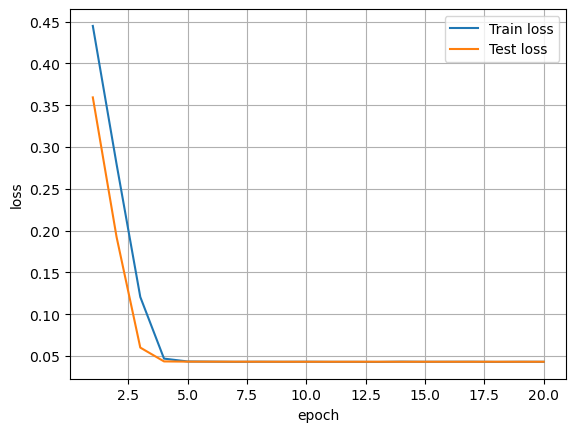

In [ ]:
class intrafeature_cnn(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3, padding=0,dtype=torch.float32, device='mps'),
            torch.nn.MaxPool1d(2),
            torch.nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3, padding=0,dtype=torch.float32, device='mps'),
            torch.nn.MaxPool1d(2),
            torch.nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3, padding=0,dtype=torch.float32, device='mps'),
            torch.nn.MaxPool1d(2),
            torch.nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3, padding=0,dtype=torch.float32, device='mps'),
            torch.nn.AdaptiveMaxPool1d(1024),
            torch.nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3, padding=1,dtype=torch.float32, device='mps'),
        )

    def forward(self, x):
        z = self.net(x)
        return z

model0d=intrafeature_cnn()

intra_train, intra_test = train(
    device='mps',
    nn=model0d,
    step_size=10,
    epochs=40,
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size=10,
    save_steps=10,
    train_loss_file=None,
    model_dir=None,
    figure=True,
    figure_file=None,
    conv_type=0
)

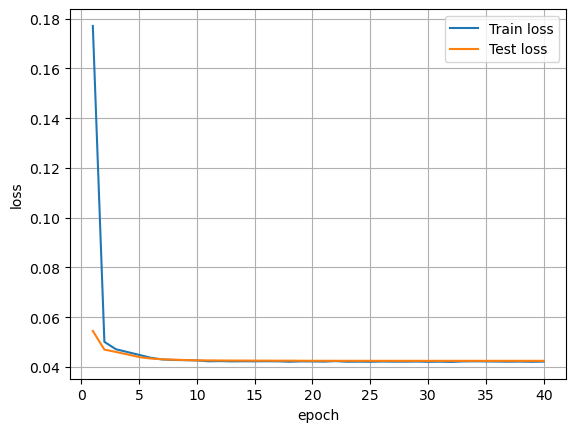

In [49]:
class cnn1d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=13,out_channels=5,kernel_size=3, padding=1,dtype=torch.float32, device='mps'),
            torch.nn.AdaptiveMaxPool1d(1024),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=5,out_channels=1,kernel_size=3, padding=1,dtype=torch.float32, device='mps')
        )

    def forward(self, x):
        z = self.net(x)
        return z

model1d=cnn1d()

flat_test, flat_train = train(
    device='mps',
    nn=model1d,
    step_size=10,
    epochs=40,
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size=10,
    save_steps=10,
    train_loss_file=None,
    model_dir=None,
    figure=True,
    figure_file=None,
    conv_type=1
)

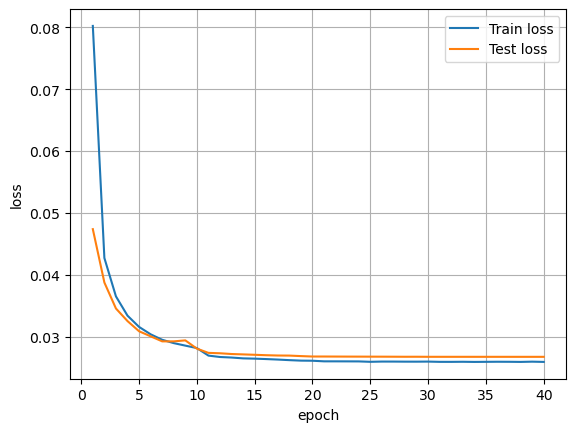

In [75]:
class cnn2d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=13,out_channels=9,kernel_size=3, padding=1,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=9,out_channels=3,kernel_size=3, padding=1,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=3,out_channels=1,kernel_size=3, padding=0,dtype=torch.float32, device='mps')
        )

    def forward(self, x):
        z = self.net(x)
        return z

model2d=cnn2d()

img_train, img_test = train(
    device='mps',
    nn=model2d,
    step_size=10,
    epochs=40,
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size=10,
    save_steps=10,
    train_loss_file=None,
    model_dir="data/example_3_2/models/",
    figure=True,
    figure_file=None,
    conv_type=2
)

## Visualization of the loss values

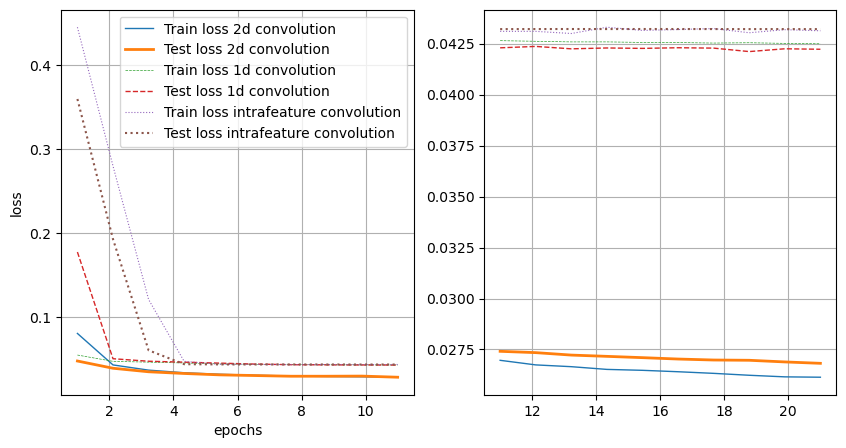

In [77]:
start = 0
end = 10
start1 = 10
end1 = 20

x= np.linspace(start+1,end+1,len(img_train[start:end]))#
x1 = np.linspace(start1+1,end1+1, len(img_train[start+1:end+1]))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=False)

ax1.plot(x, img_train[start:end],label='Train loss 2d convolution', linestyle='-', linewidth=1)
ax1.plot(x, img_test[start:end],label='Test loss 2d convolution', linestyle='-', linewidth=2)
ax1.plot(x, flat_train[start:end],label='Train loss 1d convolution', linestyle='--', linewidth=0.5)
ax1.plot(x, flat_test[start:end],label='Test loss 1d convolution', linestyle='--', linewidth=1)
ax1.plot(x, intra_train[start:end],label='Train loss intrafeature convolution', linestyle=':', linewidth=0.8)
ax1.plot(x, intra_test[start:end],label='Test loss intrafeature convolution', linestyle=':', linewidth=1.5)

ax2.plot(x1, img_train[start1:end1],label='Train loss 2d convolution', linestyle='-', linewidth=1)
ax2.plot(x1, img_test[start1:end1],label='Test loss 2d convolution', linestyle='-', linewidth=2)
ax2.plot(x1, flat_train[start1:end1],label='Train loss 1d convolution', linestyle='--', linewidth=0.5)
ax2.plot(x1, flat_test[start1:end1],label='Test loss 1d convolution', linestyle='--', linewidth=1)
ax2.plot(x1, intra_train[start1:end1],label='Train loss intrafeature convolution', linestyle=':', linewidth=0.8)
ax2.plot(x1, intra_test[start1:end1],label='Test loss intrafeature convolution', linestyle=':', linewidth=1.5)


fig.set_size_inches(10,5)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()
ax1.grid(True)
ax2.grid(True)
plt.savefig('example_3_2_loss_values.png')
plt.show()